# Analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [134]:
# External packages
import logging
import os
from random import randint
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from suite2p import default_ops, version
from IPython.utils import io

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view, dualview
from filters import KalmanDenoiser
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### General parameters

In [117]:
rootdir = '../../data/yiyuan/raw/new_experiments_201911/' # Root directory for raw data
date = '11082019'
mouse = 'mouse6'
region = 'region1'
basedir = os.path.join(rootdir, date, mouse, region)

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [118]:
# Get raw list of subolders containing tifs 
datafolders = get_data_folders(basedir, exclude_patterns=['MIP', 'References'], include_patterns=['line3'])
logger.info(f'Identified data folders:\n{pprint.pformat(datafolders)}')

 20/10/2021 21:17:00: Identified data folders:
['../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100H

### Parse experimental parameters and generate info table

In [157]:
# Parse input folders into info table
info_table = get_info_table(datafolders, ntrials_per_run=NTRIALS_PER_RUN)
# Extract singletons
tstim = get_singleton(info_table, DUR_LABEL)
fps = get_singleton(info_table, FPS_LABEL)
line = get_singleton(info_table, LINE_LABEL)
# Print info table
logger.info('Info table:')
info_table

 20/10/2021 21:38:53: Info table:


,line,trial_length,duration (s),fps,P (MPa),DC (%),run ID,code,ntrials
run,,,,,,,,,
0,line3,100,0.2,3.56,0.80,60.0,749,line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749,16
1,line3,100,0.2,3.56,0.05,50.0,756,line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC...,16
2,line3,100,0.2,3.56,0.80,5.0,748,line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748,16
3,line3,100,0.2,3.56,0.80,50.0,743,line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743,16
4,line3,100,0.2,3.56,0.60,50.0,752,line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752,16
5,line3,100,0.2,3.56,0.80,20.0,746,line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746,16
6,line3,100,0.2,3.56,0.80,30.0,745,line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745,16
7,line3,100,0.2,3.56,0.80,70.0,750,line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-750,16
8,line3,100,0.2,3.56,0.80,40.0,744,line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-744,16


### Merge TIFs into stack

In [6]:
stack_fpaths = []
for datafolder in datafolders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpaths.append(stack_tifs(datafolder, overwrite=False))

 20/10/2021 19:49:01: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 20/10/2021 19:49:01: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 20/10/2021 19:49:01: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 20/10/2021 19:49:01: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 20/10/2021 19:49:01: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752.tif" already exists
 20/10/2021 19:49:01: "/Users/tlemaire/Documents/data/yiyuan/stacked/

### Visualize a randomly chosen stack

 20/10/2021 19:49:01: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"
 20/10/2021 19:49:06: stack size: (1600, 256, 256)
 20/10/2021 19:49:06: rendering stack view...


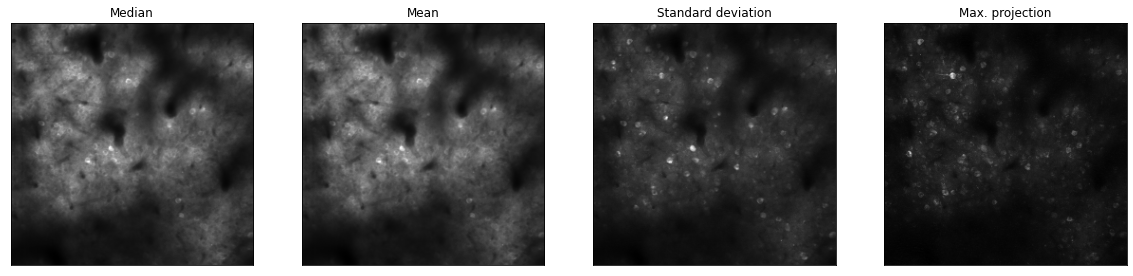

In [7]:
ifile = randint(0, len(stack_fpaths) -1)
stack = loadtif(stack_fpaths[ifile])
fig = plot_stack_summary(stack)
view(stack)

We notice a significant amount of Speckle noise in the acquired images, which must be removed.

## Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

In [8]:
# Define Kalman filter
kd = KalmanDenoiser(G=0.5, V=0.05, npad=10)

# Denoise every TIF stack and save outputs in specific directory 
filtered_stack_fpaths = filter_and_save(kd, stack_fpaths, overwrite=False)

 20/10/2021 19:49:07: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 20/10/2021 19:49:07: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756.tif" already exists
 20/10/2021 19:49:07: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748.tif" already exists
 20/10/2021 19:49:07: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743.tif" already exists
 20/10/2021 19:49:07: "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3

### View filtering output for a particular stack

 20/10/2021 19:49:07: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"
 20/10/2021 19:49:11: stack size: (1600, 256, 256)
 20/10/2021 19:49:11: rendering stacks view...


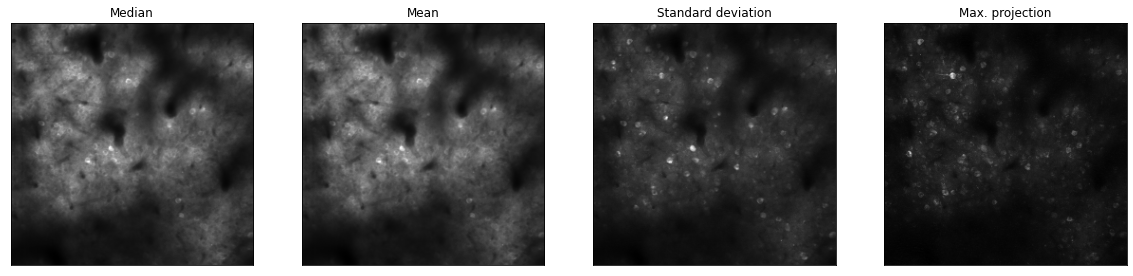

In [9]:
filtered_stack = loadtif(stack_fpaths[ifile])
fig = plot_stack_summary(filtered_stack)
dualview(stack, filtered_stack, title1='Raw', title2='Filtered', suptitle=kd)

## Functional segmentation

We will now use the suite2p pipeline to identify ROIs in our field of view and compute their fluorescence timecourse.

### Determine suite2p input data

In [10]:
# Determine input filepaths (raw or filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Get the list of folders containing the input filepaths
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
logger.info(f'Suite2p input directories:\n{pprint.pformat(s2p_input_dirs)}')

 20/10/2021 19:49:11: Suite2p input directories:
['/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1']


### Set suite2p pipeline parameters

In [11]:
# Custom options
myops = {
    'tau': TAU_GCAMP6_DECAY,  # timescale mof the sensor (in our case GCaMP6s)
    'fs': fps,  # sampling rate (per plane)
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': True,  # perform PCA denoising of the registered stack prior to ROI detection 
}

ops = default_ops()  # get default run options
ops.update(myops)  # update with personal options
logger.info(f'Suite2p {version} with run options:\n{pprint.pformat(ops)}')

 20/10/2021 19:49:11: Suite2p 0.10.2 with run options:
{'1Preg': False,
 'align_by_chan': 1,
 'allow_overlap': False,
 'anatomical_only': 0,
 'aspect': 1.0,
 'baseline': 'maximin',
 'batch_size': 500,
 'bidi_corrected': False,
 'bidiphase': 0,
 'block_size': [128, 128],
 'bruker': False,
 'bruker_bidirectional': False,
 'cellprob_threshold': 0.0,
 'chan2_thres': 0.65,
 'classifier_path': 0,
 'combined': True,
 'connected': True,
 'delete_bin': False,
 'denoise': True,
 'diameter': 0,
 'do_bidiphase': False,
 'do_registration': 1,
 'fast_disk': [],
 'flow_threshold': 1.5,
 'force_refImg': False,
 'force_sktiff': False,
 'frames_include': -1,
 'fs': 3.56,
 'functional_chan': 1,
 'h5py': [],
 'h5py_key': 'data',
 'high_pass': 100,
 'ignore_flyback': [],
 'inner_neuropil_radius': 2,
 'keep_movie_raw': False,
 'lam_percentile': 50.0,
 'look_one_level_down': False,
 'max_iterations': 20,
 'max_overlap': 0.75,
 'maxregshift': 0.1,
 'maxregshiftNR': 5,
 'mesoscan': False,
 'min_neuropil_pixels

### Run suite2p

In [12]:
run_suite2p(ops=ops, db={'data_path': s2p_input_dirs}, overwrite=False)

 20/10/2021 19:49:11: suite2p output files already exist in "/Users/tlemaire/Documents/data/yiyuan/filtered/kd_G0.5_V0.05_npad10/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0"


### Load suite2p ouput data

In [13]:
s2p_output_fpath = os.path.join(s2p_input_dirs[0], 'suite2p', 'plane0')
s2p_data = get_suite2p_data(s2p_output_fpath, withops=True)
s2p_ops = s2p_data.pop('ops')

### Plot suite2p summary images

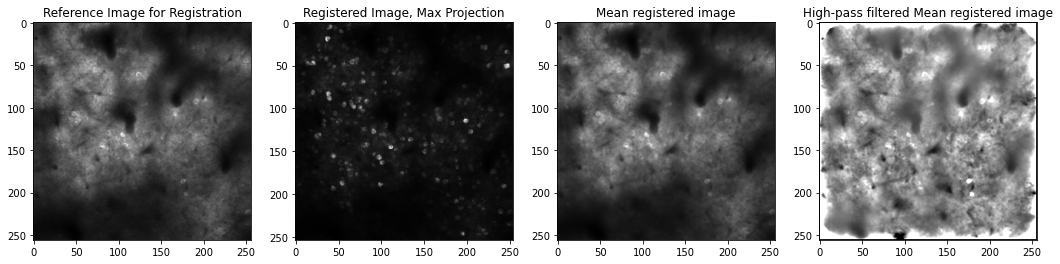

In [14]:
fig = plot_suite2p_registration_images(s2p_ops)

### Plot suite2p registration offsets

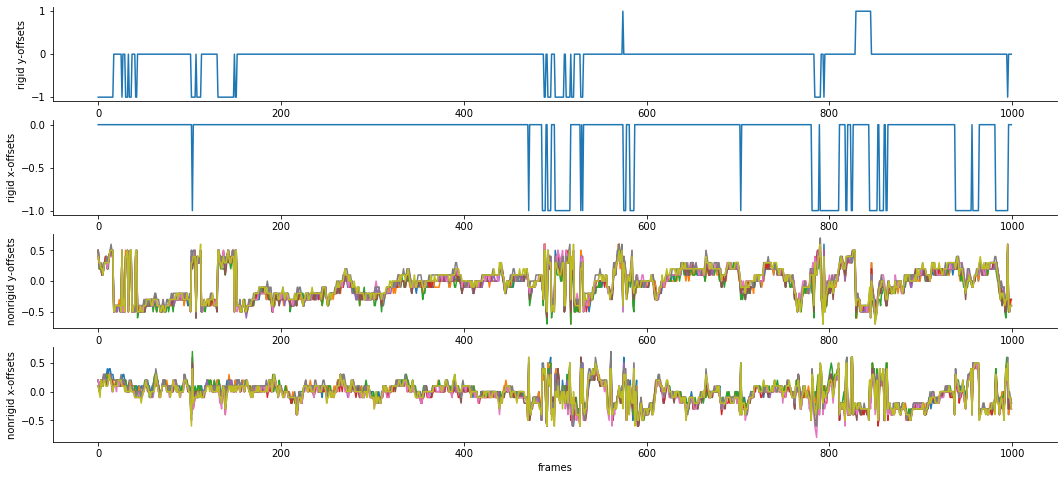

In [15]:
fig = plot_suite2p_registration_offsets(s2p_ops)

### Visualize registered stack

In [16]:
view_registered_stack(s2p_ops)

interactive(children=(IntSlider(value=800, description='t', max=1600), Output()), _dom_classes=('widget-intera…

### Inspect suite2p ROIs

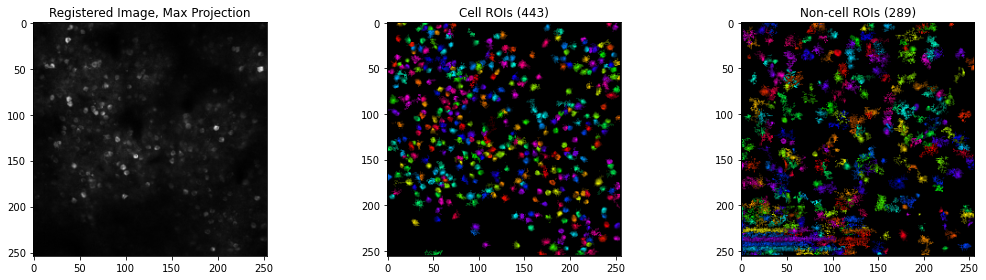

In [17]:
figs['s2p_registration'] = plot_suite2p_ROIs(s2p_data, s2p_ops)

## Post-processing

### Filter out non-cell ROIs

In [18]:
cell_data = {}
iscell, cellprob = s2p_data['iscell'].T
cell_ROI_idx = np.array(iscell.nonzero()).reshape(-1)  # ROI indexes of the cell entities
s2p_cell_data = {k: v[cell_ROI_idx] for k, v in s2p_data.items()}
del s2p_cell_data['iscell']
ncells = len(cell_ROI_idx)

### Compute fluorescence data

In [19]:
F = s2p_cell_data['F'] - NEUROPIL_FACTOR * s2p_cell_data['Fneu']

### Split the data into separate runs

In [20]:
nruns = len(s2p_input_fpaths)
F_per_run = separate_runs(F, nruns)

### Plot fluorescence timecourse for a random run 

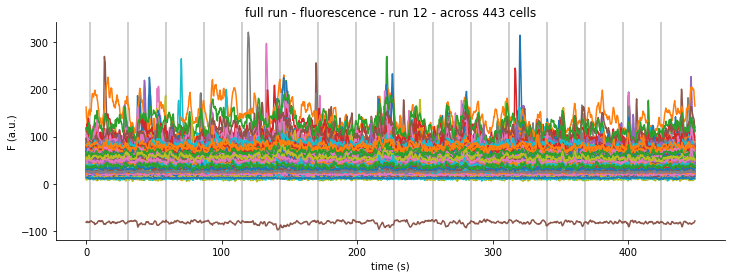

In [21]:
irun = randint(0, nruns -1)
figs['F_random_run'] = plot_run(F_per_run[:, irun, :], fps, 'F (a.u.)', title=f'fluorescence - run {irun} - across {F.shape[0]} cells', mark_stim=True)

### Split the fluorescence data into separate trials 

In [22]:
F_per_trial = separate_trials(F_per_run, NTRIALS_PER_RUN)

### <span style="color:red">TODO: Substitute stim frame for each trial???</span>

### <span style="color:red">TODO: Ignore 1st trial of each run???</span>

### Compute relative fluorescence change for each trial

In [23]:
dFF_per_trial = get_relative_fluorescence_change(F_per_trial, I_BASELINE)

### Plot Calcium transients for a particular cell and run

(merely a check that things worked correcly so far)

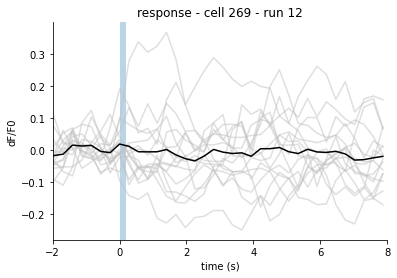

In [24]:
icell = randint(0, ncells -1)
fig = plot_response(
    dFF_per_trial[icell, irun], fps, title=f'cell {icell} - run {irun}',
    ylabel='dF/F0', avgmode=True, tstim=tstim)

### Classify cells by response type

 20/10/2021 19:49:36: computing z-score distributions
 20/10/2021 19:49:36: averaging
 20/10/2021 19:49:36: Identified response types classes:
    - negative: 50
    - neutral: 393
    - positive: 0


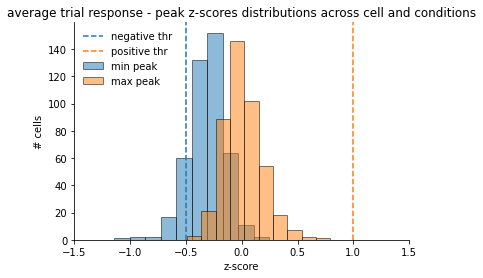

In [26]:
# Compute response type for each cell
resp_types, (zmin_dist, zmax_dist) = classify_by_response_type(dFF_per_trial, full_output=True)
s = "\n".join([f"    - {v}: {sum(resp_types == k)}" for k, v in LABEL_BY_TYPE.items()])
logger.info(f'Identified response types classes:\n{s}')
# Plot associated z-scores distributions
fig = plot_zscore_distributions(zmin_dist, zmax_dist)

### Add everything to info table

In [158]:
# Add cells and trial info to table
info_table = add_cells_to_table(info_table, cell_ROI_idx)
info_table = add_trials_to_table(info_table)
# Add fluorescence and time signals
# info_table = add_signal_to_table(info_table, 'F', F_per_trial)
info_table = add_signal_to_table(info_table, 'dF/F0', dFF_per_trial)
info_table = add_time_to_table(info_table)
# Add response type
info_table[RESP_LABEL] = resp_types[info_table.index.get_level_values('cell')]
# Log output
logger.info('info table:')
info_table

 20/10/2021 21:39:06: info table:


line  duration (s)  P (MPa)  DC (%)  run ID  \
cell run trial frame                                                 
0    0   0     0      line3           0.2      0.8    60.0     749   
               1      line3           0.2      0.8    60.0     749   
               2      line3           0.2      0.8    60.0     749   
               3      line3           0.2      0.8    60.0     749   
               4      line3           0.2      0.8    60.0     749   
...                     ...           ...      ...     ...     ...   
442  14  15    95     line3           0.2      0.4    50.0     753   
               96     line3           0.2      0.4    50.0     753   
               97     line3           0.2      0.4    50.0     753   
               98     line3           0.2      0.4    50.0     753   
               99     line3           0.2      0.4    50.0     753   

                                                                   code  \
cell run trial frame                                                      
0    0   0     0      line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749   
               1      line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749   
               2      line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749   
               3      line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749   
               4      line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749   
...                                                                 ...   
442  14  15    95     line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753   
               96     line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753   
               97     line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753   
               98     line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753   
               99     line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-753   

                      ntrials     dF/F0   time (s)  response type  
cell run trial frame                                               
0    0   0     0           16 -0.037533  -2.808989              0  
               1           16 -0.085667  -2.528090              0  
               2           16 -0.076062  -2.247191              0  
               3           16 -0.057647  -1.966292              0  
               4           16 -0.005426  -1.685393              0  
...                       ...       ...        ...            ...  
442  14  15    95          16  0.025498  23.876404             -1  
               96          16 -0.005135  24.157303             -1  
               97          16 -0.047424  24.438202             -1  
               98          16  0.046509  24.719101             -1  
               99          16 -0.025364  25.000000             -1  

[10632000 rows x 10 columns]

## Results visualization 

### Spatial distribution of cells per response type

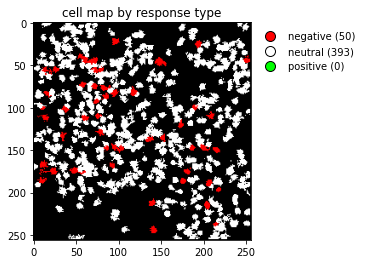

In [159]:
figs['cellmap'] = plot_cell_map(s2p_cell_data['stat'], info_table, title='cell map by response type')

### Cluster map of cell responses

/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


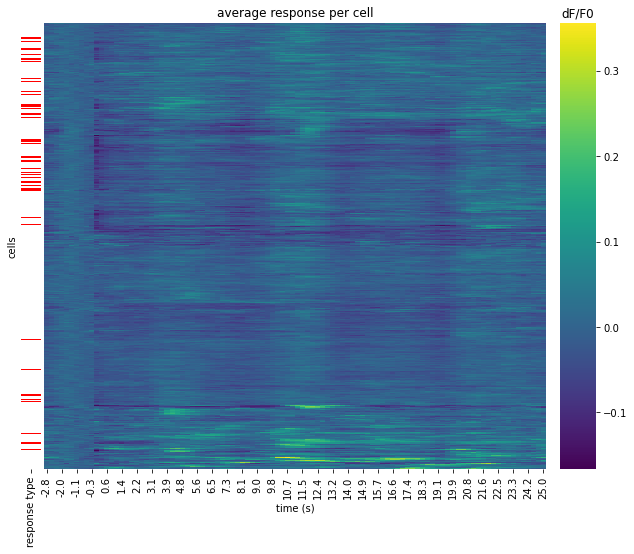

In [160]:
figs['clustermap'] = plot_experiment_heatmap(info_table, title='average response per cell')

### <span style="color:red">TODO: Remove outliers???</span>

In [161]:
avg_resp_per_cell = info_table.pivot_table(
    index=TIME_LABEL, columns='cell', values='dF/F0', aggfunc=np.mean)

In [185]:
data = info_table.loc[(icell, irun)].pivot_table(index=TIME_LABEL, columns='trial', values='dF/F0')
data

trial,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
time (s),,,,,,,,,,,,,,,,
-2.808989,0.088539,-0.003620,-0.084976,-0.136561,0.013814,0.002377,-0.040676,-0.015556,0.167241,0.072138,-0.123432,-0.068471,0.045726,-0.071062,0.004506,-0.015199
-2.528090,-0.059274,-0.049271,-0.066464,-0.080435,-0.016625,0.062828,-0.088060,-0.075129,0.131369,0.009696,-0.114754,-0.032589,0.050721,0.037189,-0.056453,0.008139
-2.247191,-0.057916,-0.073160,-0.070804,0.004055,-0.029648,0.031482,-0.005397,0.012510,0.105600,0.005571,-0.068800,0.030709,-0.047089,0.016029,-0.067987,-0.082473
-1.966292,-0.056623,-0.047720,-0.096466,0.073959,-0.035411,-0.005444,-0.038830,-0.017545,0.107135,0.029134,-0.092209,-0.013721,-0.040405,0.011101,-0.032603,-0.022831
-1.685393,-0.053007,-0.027783,-0.055526,0.025667,0.005970,-0.006245,-0.032082,0.030710,0.019409,-0.005471,-0.109812,0.061679,-0.054924,0.052883,-0.067190,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23.876404,-0.053843,0.096615,0.054487,-0.042072,-0.159584,-0.108058,0.152836,0.152672,-0.080343,0.181177,-0.126117,-0.080097,-0.038531,0.046045,0.077028,0.014409
24.157303,0.002269,0.177993,0.075339,-0.118824,-0.171666,-0.126892,0.152707,0.109640,-0.072041,0.189111,-0.176943,-0.092468,-0.029050,0.057773,-0.000196,0.002622
24.438202,0.097329,0.101890,-0.009615,-0.116284,-0.081786,-0.140141,0.160708,0.094837,-0.093284,0.244305,-0.146106,-0.127868,-0.069712,0.018585,0.104242,-0.020203


In [188]:
for x in data:
    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [178]:
fig = plot_response(
    dFF_per_trial[0, irun], fps, title=f'cell {icell} - run {irun}',
    ylabel='dF/F0', avgmode=True, tstim=tstim)

TypeError: plot_response() missing 1 required positional argument: 'irun'

### Plot average Calcium transients across cells

In [97]:
# Average fluorescence data across trials
dFF_trial_avg = dFF_per_trial.mean(axis=1)
print(dFF_per_trial.shape)
fig = plot_response(
    dFF_per_trial[:, irun], FPS, title=f'{k} - across {ncells} cells',
    ylabel='dF/F0', avgmode=True, tstim=tstim)

(443, 15, 16, 100)


NameError: name 'k' is not defined